fraud_model_training.ipynb
📌 This notebook performs:
- Data loading & feature engineering
- Handling class imbalance (SMOTE)
- Training a LightGBM model using pipeline
- Model evaluation with metrics & plots
- Saving the trained model


📦 1. Import Libraries

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve
)

from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib

# General setup
warnings.filterwarnings("ignore")


📂 2. Load Dataset

In [46]:
df = pd.read_csv("Fraud_Analysis_Dataset.csv")

# Print class distribution
fraud_counts = df["isFraud"].value_counts()
fraud_percentages = df["isFraud"].value_counts(normalize=True) * 100
print(f"Non-Fraud: {fraud_counts[0]} transactions ({fraud_percentages[0]:.1f}%)")
print(f"Fraud:     {fraud_counts[1]} transactions ({fraud_percentages[1]:.1f}%)")

Non-Fraud: 10000 transactions (89.8%)
Fraud:     1142 transactions (10.2%)


🛠️ 3. Feature Engineering

In [47]:
from utils import transform_features  # ✅ Ensure this file is present and correct
df = transform_features(df)

df.head()

,step,type,amount,nameOrig,nameDest,isFraud,balance_diff_orig,balance_diff_dest,error_balance_orig,error_balance_dest
0,1,TRANSFER,181.0,C1305486145,C553264065,1,181.0,0.0,0.0,181.0
1,1,CASH_OUT,181.0,C840083671,C38997010,1,181.0,-21182.0,0.0,21363.0
2,1,TRANSFER,2806.0,C1420196421,C972765878,1,2806.0,0.0,0.0,2806.0
3,1,CASH_OUT,2806.0,C2101527076,C1007251739,1,2806.0,-26202.0,0.0,29008.0
4,1,TRANSFER,20128.0,C137533655,C1848415041,1,20128.0,0.0,0.0,20128.0


🎯 4. Define Features and Target

In [48]:
y = df["isFraud"]
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest', 'step', 'type'])

# Separate numerical and categorical columns
numeric = X.select_dtypes(include='number').columns.tolist()
categorical = X.select_dtypes(include='object').columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


⚖️ 5. Handle Class Imbalance (SMOTE)

In [49]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\n✅ After SMOTE:", y_train_resampled.value_counts())


✅ After SMOTE: isFraud
0    7999
1    7999
Name: count, dtype: int64


🔍 6. Preprocessing + Model Pipeline

In [50]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric),
    ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), categorical)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LGBMClassifier(random_state=42))
])

# Train on resampled data
pipeline.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 7999, number of negative: 7999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15998, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount',
                                                   'balance_diff_orig',
                                                   'balance_diff_dest',
                                                   'error_balance_orig',
                                                   'error_balance_dest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  [])])),
                ('clf', LGBMClassifier(random_state=42))])

🧪 7. Model Evaluation

In [51]:
# 1. Create 'images' folder if it doesn't exist
os.makedirs("images", exist_ok=True)

# 2. Predict on test data
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# 3. Classification Report
print("📋 Classification Report:")
report = classification_report(y_test, y_pred)
print(report)

# 4. Save Classification Report to a text file (optional)
with open("images/classification_report.txt", "w") as f:
    f.write(report)

# 5. Confusion Matrix
print("📌 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("images/confusion_matrix.png")
plt.close()

# 6. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("images/roc_curve.png")
plt.close()

# 7. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.savefig("images/pr_curve.png")
plt.close()

print("✅ All evaluation results saved to the 'images/' folder.")

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2001
           1       0.75      0.87      0.80       228

    accuracy                           0.96      2229
   macro avg       0.87      0.92      0.89      2229
weighted avg       0.96      0.96      0.96      2229

📌 Confusion Matrix:
✅ All evaluation results saved to the 'images/' folder.


💾 8. Save Model

In [52]:
joblib.dump(pipeline, "fraud_detection_pipeline.pkl")

['fraud_detection_pipeline.pkl']

📊 9. Feature Importance

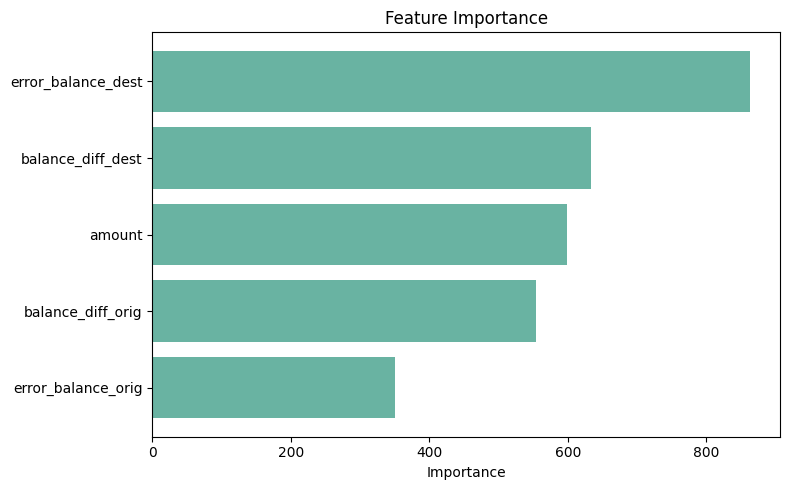

In [53]:
pipeline = joblib.load("fraud_detection_pipeline.pkl")
model = pipeline.named_steps["clf"]
preprocessor = pipeline.named_steps["prep"]

# Get feature names from ColumnTransformer
feature_names = preprocessor.transformers_[0][2]  # numeric features only
importances = model.feature_importances_

# Plot
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#69b3a2')
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()